# Vector data

Authors: David Shean & Scott Henderson

SnowEx Hackweek July 13, 2021

```{admonition} Learning Objectives
*A 30 minute guide to vector data for SnowEX Hackweek*
- find, visualize, interpret vector data formats
- use Python raster libraries [geopandas](https://geopandas.readthedocs.io/en/stable/)
```

## GeoPandas

pandas is great, but what if we want to do some geospatial operations - like reproject our vector data or compute the intersection between Point and Polygon features?

Enter Geopandas - all the great things about pandas, plus geo! (http://geopandas.org/).

>"GeoPandas is an open source project to make working with geospatial data in python easier. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by shapely. Geopandas further depends on fiona for file access and descartes and matplotlib for plotting."

>"GeoPandas enables you to easily do operations in python that would otherwise require a spatial database such as PostGIS."

Under the hood, GeoPandas is `pandas` plus some other core geospatial packages:
* `shapely` for geometry operations (https://shapely.readthedocs.io/en/stable/manual.html)
* `fiona` for reading/writing GIS file formats (https://fiona.readthedocs.io/en/latest/manual.html)
* `pyproj` for projections and coordinate system transformations (http://pyproj4.github.io/pyproj/stable/)

Under those hoods are lower-level geospatial libraries (GEOS, GDAL/OGR, PROJ), written in C/C++/Java and compiled (fast!), that provide a foundation for most GIS software (open-source and commercial).  I encourage you to explore these - I guarantee you will learn something valuable.

* `GEOS` https://trac.osgeo.org/geos/
* `GDAL/OGR` https://gdal.org/
* `PROJ` https://proj.org/

For now, let's explore some basic geopandas functionality.

In [1]:
import geopandas as gpd
import hvplot.pandas
import holoviews as hv

### GeoDataFrame
* https://geopandas.org/data_structures.html
* Indexing and selection - `iloc`, `loc`

In [ ]:
gpd.GeoDataFrame?

### Coordinate Reference Systems (CRS)
These are essential for geospatial analysis, but can be confusing (even for seasoned GIS professionals). Fortunately, most applications use common CRS with a shared database of EPSG codes. https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset

Here are some common CRS you will encounter:
* EPSG:4326 - WGS84, geodetic latitude and longitude
* EPSG:3857 - "web mercator", used by most tiled basemaps and online/mobile mapping platforms, https://en.wikipedia.org/wiki/Web_Mercator_projection
    * Usually OK for display purposes, maybe some analysis at lower latitudes, but considerable distortion at high latitudes
* UTM zones - convenient compromise projections for smaller areas (<500 km)
    * EPSG:326XX - where XX is zone number (e.g., 12), WGS84 ellipsoid
    * EPSG:269XX - where XX is zone number, NAD83(2011) ellipsoid

### Key takeaways for now:
* Make sure your dataset has a CRS defined (consult metadata if unspecified)
* While ArcGIS/QGIS can reproject datasets to a common CRS "on the fly" 
* GeoPandas/Shapely/GEOS performs calculations using 2D Cartesian coordinates (e.g., computing distance with Pythagorean theorem, not true 3D geodetic distance on surface of the Earth). Choice of CRS for these calculations is important (e.g., use equal-area projection for area calculations)
* Most of the time, you will use one of the above CRS definitions. For larger regional analysis, consider a custom projection defined by your domain and planned analysis: https://projectionwizard.org/

## Let's use some Polygons for US States

Hmmm, let's see.  Two choices:
1. We could go to ESRI or the U.S. Census website, identify and download a shapefile, unzip 4+ files, copy/paste the appropriate \*.shp filename into the notebook.  Wait, how can I download on a remote server?  OK, maybe run something like `wget http://...`, unzip, provide absolute path  
*- OR -*
2. Give geopandas a url string that points to a GeoJSON file somewhere on the web, and read dynamically

Yeah, let's go with #2

Let's use the US States 5M GeoJSON here: http://eric.clst.org/tech/usgeojson/

* JSON (JavaScript Object Notation) is a structured text-based data format. A Jupyter notebook is a json text file. 
* GeoJSON extends this format to include geospatial information. It's pretty great. If you are unfamiliar, take a moment to read about GeoJSON: https://en.wikipedia.org/wiki/GeoJSON

Take a look at the 5M file contents in your browser or download and open with a text editor.  Note organization structure.  How does this compare to, say, a Python dictionary object? 

This is a GeoJSON file!

Read the file using GeoPandas by passing the url to `gpd.read_file()`.

In [2]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
#states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_gdf = gpd.read_file(states_url)

In [3]:
states_gdf.head()

GEO_ID STATE        NAME LSAD  CENSUSAREA  \
0  0400000US01    01     Alabama        50645.326   
1  0400000US02    02      Alaska       570640.950   
2  0400000US04    04     Arizona       113594.084   
3  0400000US05    05    Arkansas        52035.477   
4  0400000US06    06  California       155779.220   

                                            geometry  
0  MULTIPOLYGON (((-88.12466 30.28364, -88.08681 ...  
1  MULTIPOLYGON (((-166.10574 53.98861, -166.0752...  
2  POLYGON ((-112.53859 37.00067, -112.53454 37.0...  
3  POLYGON ((-94.04296 33.01922, -94.04304 33.079...  
4  MULTIPOLYGON (((-122.42144 37.86997, -122.4213...

<Axes: >

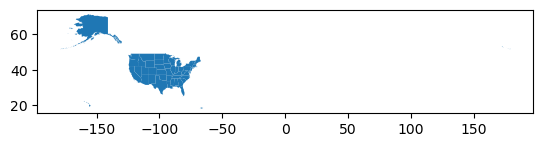

In [4]:
states_gdf.plot()

### Check the CRS
* Note that this was defined when we opened the file with GeoPandas - by default, a GeoJSON is assumed to use EPSG:4326 coordinate system for geodetic latitude and longitude

In [5]:
states_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
states_gdf.hvplot()

:Polygons   [x,y]

In [7]:
states_gdf.hvplot(geo=True)

:Polygons   [Longitude,Latitude]

## Reprojection and Coordinate Systems

All of the above examples used standard geodetic lat/lon coordinate system (EPSG:4326).  This is fine for global analyses and basic visualization.  But remember that the width of a degree of longitude varies with latitude (~111 km near equator, ~0 m near pole), so our plots have scaling and aspect ratio issues.

We need to choose a map projection that is appropriate for our data. This decision is important for visualization, but is also critical for precise quantitative analysis. For example, if you want to compute area or volume change, you should use an equal-area projection. If you want to calculate distances between two points, you should use an equidistant projection.

https://www.axismaps.com/guide/general/map-projections/

Sadly, there is no "perfect" projection. You, as the mapmaker or data analyst, are responsible for choosing a projection with the right characteristics for your purposes. 

Let's explore a bit further, and we'll revisit some general guidelines later.

### Use GeoPandas to reproject your GeoDataFrame

* Use the very convenient `to_crs()` method to reproject: https://geopandas.org/projections.html
* Start by reprojecting the points to a Universal Transverse Mercator (UTM), Zone 12N (EPSG:26912)
    * https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system#/media/File:Utm-zones-USA.svg
* Store the output as a new GeoDataFrame
* Do a quick `head()` and note the new values in the `geometry` column

### Original data (note geometry values)

In [ ]:
states_gdf.head()

In [ ]:
states_gdf_utm = states_gdf.to_crs('EPSG:26912')

In [ ]:
states_gdf_utm.head()

In [ ]:
print(states_gdf.crs)
print(states_gdf_utm.crs)

In [ ]:
states_gdf_utm.crs

*Note: Our map will have limited distortion (area, distance, angles) within the zone centered on -111°W.  But distortion will increase beyond the width of the -114° to -108°W zone definition.*

In [ ]:
states_gdf_utm.hvplot(aspect='equal', title='UTM 12N') * hv.VLine(0).opts(color='k', line_width=0.5)

Note: the apparent origin (0 on the x axis) seems farther west than expected.

🤔 What's going on here? 

All UTM projections have a "false easting" of 500 km (1/2 the zone width) to ensure that map coordinates are always positive (simplifies math). So the actual center longitude of the projection is as defined, but the coordinate values are offset. Confusing, but now you know what a "false easting" is.

In [ ]:
states_gdf_utm.hvplot(aspect='equal', title='UTM 12N') * hv.VLine(500000).opts(color='r', line_width=0.5)

In [ ]:
states_gdf.to_crs('EPSG:26913').hvplot(aspect='equal', title='UTM 13N') * hv.VLine(500000).opts(color='r', line_width=0.5)

## CRS Summary

Excellent, but what did we just do?

Under the hood, GeoPandas used the `pyproj` library (a Python API for PROJ) to transform each point from one coordinate system to another coordinate system.  

I guarantee that you've all done this kind of thing before, you may just not remember it or recognize it in this context. See: https://en.wikipedia.org/wiki/List_of_common_coordinate_transformations

In 2D, transforming (x,y) coordinates between different projections (e.g., WGS84 vs. UTM) on the same reference ellipsoid is pretty straightforward.  Things start to get more complicated when you include different ellipsoid models, horizontal/vertical datums, etc.  Oh, also the Earth's surface is not static - plate tectonics make everything more complicated, as time becomes important, and transformations must include a "kinematic" component.  

Fortunately, the `PROJ` library (https://proj.org/about.html) has generalized much of the complicated math for geodetic coordinate transformations.  It's been under development since the 1980s, and our understanding of the Earth's shape and plate motions has changed dramatically in that time period.  So, still pretty complicated, and there are different levels of support/sophistication in the tools/libraries that use `PROJ`.

We aren't going to get into the details here, but feel free to take a look at the Transformations section here to get a sense of how this is actually accomplished: https://proj.org/operations/index.html